# Aufgabe 3: Data Preparation und Modeling 

In [11]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [12]:
dataset = pd.read_csv('./DatenAusgegeben1.0.csv', delimiter=';', encoding = 'cp852')
dataset

,Grundstück in qm,Grundstücksform,Steigung,Bezirk,Zone,Lage,Typ,Zustand,Gebaut,Renoviert,...,Schlafzimmer,Küchen,Küchenqualitt,Rume,Garage Typ,Garagenkapazitt,Pool,Verkaufsmonat,Verkaufsjahr,Preis
0,898,IR1,Nein,Somerset,RL,Norm,2Fam,4,2107,2107,...,6,2,3,10,Anbau,2,NaN,8,2136,156500
1,1326,Reg,Nein,North East,RL,Norm,1Fam,5,2133,2133,...,3,1,4,7,Anbau,3,NaN,1,2137,350000
2,725,Reg,Nein,Somerset,RL,Norm,1Fam,7,2096,2138,...,3,1,4,5,Freistehend,1,NaN,6,2140,137900
3,725,Reg,Nein,Somerset West,RL,Norm,1Fam,5,2135,2135,...,3,1,4,8,Anbau,2,NaN,4,2136,184000
4,697,Reg,Nein,Miller,RL,Norm,1Fam,5,2129,2129,...,3,1,4,7,Anbau,2,NaN,6,2140,189000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1272,IR1,Nein,North East,RL,Norm,1Fam,5,2133,2134,...,3,1,5,10,Eingebaut,3,NaN,3,2138,412500
1996,941,IR1,Nein,Miller,RL,Norm,1Fam,5,2134,2134,...,3,1,4,7,Anbau,2,NaN,7,2139,195500
1997,1093,Reg,Nein,Grand Park,RL,Norm,1Fam,7,2040,2130,...,2,1,3,6,Freistehend,1,NaN,5,2137,112000
1998,1228,IR1,Nein,North East,RL,Norm,1Fam,5,2134,2134,...,3,1,4,9,Eingebaut,3,NaN,2,2136,279000


## Unnötige Spalten entfernen
Zu entfernen sind:  
Siehe Aufg. 2. Untersuchung auf einen Zusammenhang zwischen Preis und Verkaufszeitpunkt:
- Verkaufsjahr
- Verkaufsmonat

(Da Gesamtwohnfläche zusammengesetzt aus erster Stock und zweiter Stock ist:
- Erster Stock in qm
- Zweiter Stock in qm
#TODO: Prüfen ob nicht rauszunehmen)

Siehe Aufg. 2. Untersuchung des Datensatzes auf vernachlässigbare Hauseigenschaften (Spalten):
- Pool
- Küchen
- Klimaanlage
- Heizung

In [13]:
df_keinunnoetig = dataset.drop(['Verkaufsjahr', 'Verkaufsmonat', 'Erster Stock in qm', 'Zweiter Stock in qm', 'Pool', 'Küchen', 'Klimaanlage', 'Heizung'], axis = 1)

## Anomalien bereinigen
Nun sollen Anomalien in dem Datensatz gefunden und bereinigt werden.
Hierbei wird der Interquartilsabstand verwendet um Ausreißer zu finden.  
(https://en.wikipedia.org/wiki/Interquartile_range)  

Hierbei sollen ausschließlich numerische Werte, also keine Werte einer ordinalen Skala betrachtet werden. (`columns_filtered`)

Bereits in Aufgabe 2 erkannte und zu bereinigende Anomalien sind:
- Bezirksname `Somerst` anstatt `Somerset`
- Ausreißer im Datensatz

In [14]:
df_keinunnoetig['Bezirk'] = df_keinunnoetig['Bezirk'].replace('Somerst', 'Somerset') # Bezirksname korrigieren

columns = ['Grundstück in qm', 'Zustand', 'Gebaut',
           'Renoviert', 'Zustand Fassade', 'Kellerflche in qm',
           'Wohnflche in qm', 'Schlafzimmer', 'Küchenqualitt', 
           'Rume', 'Garagenkapazitt', 'Preis']

columns_filtered = ['Grundstück in qm', 'Kellerflche in qm', 'Wohnflche in qm', 
           'Schlafzimmer', 'Gebaut', 'Rume', 'Garagenkapazitt', 'Preis']

Q1 = df_keinunnoetig[columns_filtered].quantile(0.25)
Q3 = df_keinunnoetig[columns_filtered].quantile(0.75)
IQR = Q3 - Q1 # Interquartilsabstand berechnen

df_anomalienbereinigen = df_keinunnoetig[~((df_keinunnoetig[columns_filtered] < (Q1 - 1.5 * IQR)) | (dataset[columns_filtered] > (Q3 + 1.5 * IQR))).any(axis=1)] # Anomalien außerhalb des Interquartilsabstands entfernen

## Verifikation der Bereinigung
Nun soll verifiziert werden, ob die Bereinigung auf Anomalien erfolgreich gewesen ist. Hierzu können die untenstehenden Boxplots mit denen aus **Aufg. 2, Finden von Anomalien** verglichen werden.

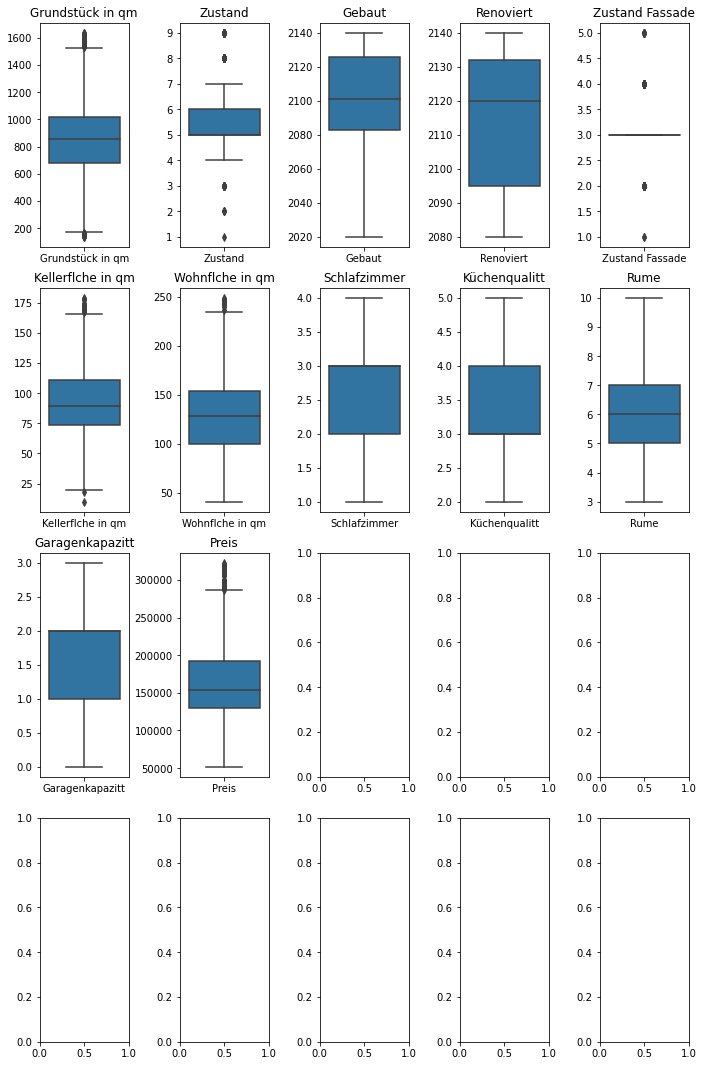

In [15]:
fig, axes = plt.subplots(4, 5, figsize = (10, 15))
i = 0
plt.tight_layout(pad = 2)
for column in columns:
  chosenax = axes[math.floor(i / 5)][i % 5]
  chosenax.set_title(column)
  sb.boxplot(data = df_anomalienbereinigen[[column]], ax = chosenax)
  i = i + 1
plt.show()

## Feature Engineering
Folgend soll das One-Hot Encoding auf alle geeigneten Kategorien angewendet werden.

Den Bezirken ist ein weiterer Bezirk, `Finger River` hinzuzufügen, welcher in der Datenbeschreibung, jedoch nicht im Datensatz vorhanden ist.

In [16]:
encode_kategorien = ['Bezirk', 'Lage', 'Heizungsqualitt', 'Typ', 'Steigung', 'Grundstücksform', 'Garage Typ', 'Zone']

encoded_kategorieeigenschaften = pd.get_dummies(dataset[encode_kategorien].fillna('Keine'))
encoded_kategorieeigenschaften['Bezirk_Finger River'] = 0
df_encoded = df_anomalienbereinigen.drop(encode_kategorien, axis = 1).join(encoded_kategorieeigenschaften)

print(df_encoded)

      Grundstück in qm  Zustand  Gebaut  Renoviert  Zustand Fassade  \
2                  725        7    2096       2138                3   
3                  725        5    2135       2135                3   
4                  697        5    2129       2129                3   
5                 1274        5    2080       2080                3   
7                  211        5    2133       2134                3   
...                ...      ...     ...        ...              ...   
1994               948        8    2070       2127                3   
1996               941        5    2134       2134                3   
1997              1093        7    2040       2130                3   
1998              1228        5    2134       2134                3   
1999               778        7    2071       2103                3   

      Kellerflche in qm  Wohnflche in qm  Schlafzimmer  Küchenqualitt  Rume  \
2                    80               83             3              

## Aufspaltung nach Trainings- und Validierungsset

In [17]:
df_train = df_encoded.drop('Preis', axis = 1)
values_predict = df_encoded['Preis']
x_train, x_test, y_train, y_test = train_test_split(df_train, values_predict, test_size = 0.2)

## Lineare Regression

In [18]:
print(x_train.columns)
reg1 = LinearRegression()
reg1.fit(x_train, y_train)
print(reg1)

Index(['Grundstück in qm', 'Zustand', 'Gebaut', 'Renoviert', 'Zustand Fassade',
       'Kellerflche in qm', 'Wohnflche in qm', 'Schlafzimmer', 'Küchenqualitt',
       'Rume', 'Garagenkapazitt', 'Bezirk_Burnley', 'Bezirk_ChinaTown',
       'Bezirk_City Hall', 'Bezirk_Clear Creek', 'Bezirk_DiamondDistrict',
       'Bezirk_Dixon Side', 'Bezirk_East End', 'Bezirk_Fashion District',
       'Bezirk_Grand Park', 'Bezirk_Miller', 'Bezirk_New Gotham',
       'Bezirk_North East', 'Bezirk_North West', 'Bezirk_Novick District',
       'Bezirk_Old Gotham', 'Bezirk_Paris Island', 'Bezirk_Robinson Park',
       'Bezirk_Somerset', 'Bezirk_Somerset West', 'Bezirk_Somerst',
       'Bezirk_The Bowery', 'Bezirk_Tricorner', 'Bezirk_University',
       'Bezirk_Upper West', 'Bezirk_Water District', 'Lage_Bahn', 'Lage_Norm',
       'Lage_Pos', 'Lage_Str', 'Heizungsqualitt_Ex', 'Heizungsqualitt_Gut',
       'Heizungsqualitt_Schl', 'Heizungsqualitt_Ty', 'Heizungsqualitt_Ud',
       'Typ_1Fam', 'Typ_2Fam', 'Typ_

## Random Forest
Finden von optimalen Parametern mithilfe von Gridsearch und Crossvalidation

In [19]:
RFR=RandomForestRegressor()

search_grid_rfr = {'n_estimators': [100,200,300,400,500,1000], 'max_features': ['auto', 'sqrt']}

search = GridSearchCV(estimator = RFR, param_grid = search_grid_rfr, n_jobs = -1, cv = 5, verbose = 8)

search.fit(x_train, y_train)
print("Bestes gefundenes Modell:", search.best_estimator_)
print("Bester Score:", search.best_score_)
reg2 = search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:   15.7s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:   19.9s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   21.3s finished
Bestes gefundenes Modell: RandomForestRegressor()


## Gradient Tree Boosting
Ebenso finden von optimalen Parametern mithilfe von Gridsearch und Crossvalidation

In [20]:
GBR=GradientBoostingRegressor()

search_grid_gbr = {'n_estimators':[100,500,1000], 'learning_rate':[0.01,0.05,.1], 'max_depth':[2,3,4,5], 'subsample':[.75,1,1.25]}

search=GridSearchCV(estimator = GBR, param_grid = search_grid_gbr, n_jobs = -1, cv = 5, verbose = 8)

search.fit(x_train, y_train)
print("Bestes gefundenes Modell:", search.best_estimator_)
print("Bester Score:", search.best_score_)
reg3 = search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 245 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.0min finished
Bestes gefundenes Modell: GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=1000,
                          subsample=1)


## Vergleichen der Modelle (R^2)

In [21]:
print("Linear Regression\t\t\t", reg1.score(x_test, y_test))
print("Random Forest Regression\t\t", reg2.score(x_test, y_test))
print("Gradient Tree Boosting Regression\t", reg3.score(x_test, y_test))

Linear Regression			 0.890723338230859
Random Forest Regression		 0.878262069097791
Gradient Tree Boosting Regression	 0.8977628735465357


## Visueller Vergleich der Modelle
Um die Modelle visuell zu vergleichen wird folgend zunächst der Testdatensatz zusammen mit den vorhergesagten Preisen aufsteigend sortiert um eine bessere Visualisierung zu ermöglichen. Daraufhin werden die Regressionsmodelle visuell verglichen. 

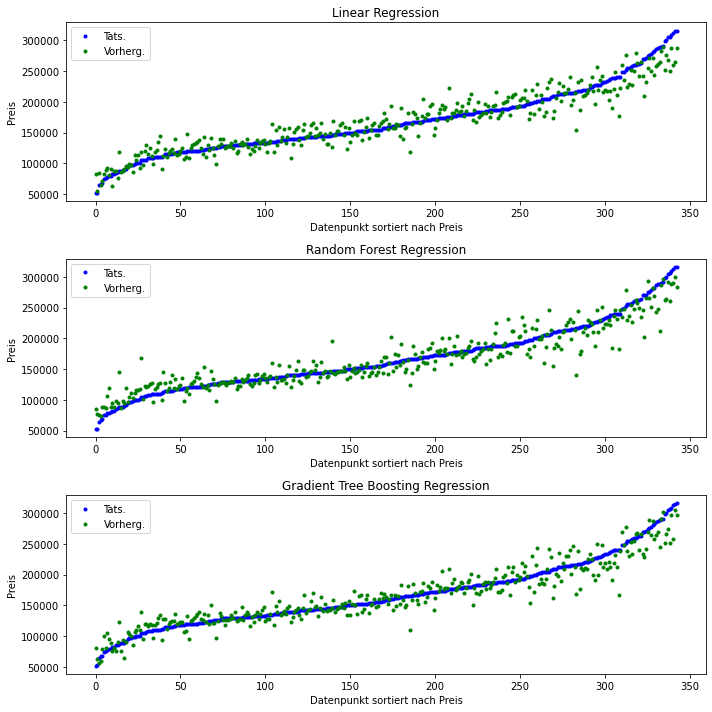

In [22]:

plt.figure(figsize = (10, 10))

i = 1
for reg in [(reg1, 'Linear Regression'), (reg2, 'Random Forest Regression'), (reg3, 'Gradient Tree Boosting Regression')]:
    y_pred = reg[0].predict(x_test)
    y_test_sort, y_pred_sort = zip(*sorted(zip(y_test, y_pred))) ## Synchrones sortieren
    plt.subplot(3,1,i)
    i = i + 1
    plt.plot(range(0, len(y_test_sort)), y_test_sort, 'b.', label = 'Tats.')
    plt.plot(range(0, len(y_pred_sort)), y_pred_sort, 'g.', label = 'Vorherg.')
    plt.xlabel('Datenpunkt sortiert nach Preis')
    plt.ylabel('Preis')
    plt.legend(loc = 'upper left')
    plt.title(reg[1])

plt.tight_layout()
plt.show()

### Erkenntnis
Aus den oben gezeigten Plots und dem Vergleich der R^2 Metrik zeigt sich, dass alle drei Modelle sehr genau in der Vorhersage arbeiten, jedoch die `Gradient Tree Boosting Regression` wie erwartet (da zum jetzigen Zeitpunkt State of the Art) die besten Ergebnisse liefert.  

Daher wählen wir als finales Modell die `Gradient Tree Boosting Regression`.

## Export des Modells

In [24]:
from joblib import dump
dump(reg3, 'gradientboosted2.model')

['gradientboosted2.model']